In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import mne
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '../')
from esinet import util
from esinet import Simulation
from esinet import Net
from esinet.forward import get_info, create_forward_model
import os
plot_params = dict(surface='white', hemi='both', verbose=0)


In [2]:
info = get_info()
fwd = create_forward_model(info=info, sampling='ico3')
leadfield = util.unpack_fwd(fwd)[1]

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.5s remaining:    2.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.6s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


In [3]:
settings = dict(duration_of_trial=0.1)
sim = Simulation(fwd, info, settings=settings, parallel=False).simulate(1000)
idx = 0
sim.source_data[idx].plot(**plot_params)

-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 1000/1000 [00:00<00:00, 11905.83it/s]


source data shape:  (1284, 100) (1284, 100)


100%|██████████| 1000/1000 [00:16<00:00, 62.48it/s]


In [72]:
import tensorflow as tf
from tensorflow.keras import backend as K
def custom_loss(leadfield, dtype=tf.float32):
    leadfield_ = tf.convert_to_tensor(leadfield, dtype=dtype)
    # time_points, dipoles = [100, 1284]
    def loss_batch(y_true, y_pred):
        def lss(y_true, y_pred):
            error = K.mean(K.square(y_true-y_pred)) 
            sparsity = K.mean(K.abs(y_true))#*10 
            
            # y_true = tf.transpose(tf.reshape(y_true, (batch_size*time_points, dipoles)))
            # y_pred = tf.transpose(tf.reshape(y_pred, (batch_size*time_points, dipoles)))
            print("LOOOOOOK ", y_true.shape, y_pred.shape)
            x_true = K.flatten(tf.matmul(leadfield_,y_true))
            x_pred = K.flatten(tf.matmul(leadfield_,y_pred))
                    
            forward_error = tf.keras.losses.CosineSimilarity()(x_true, x_pred)
            # return  error + sparsity + forward_error
            return sparsity + forward_error

        batched_losses = tf.map_fn(lambda x:
                                lss(x[0], x[1]),
                                (y_true, y_pred))
        return K.mean(tf.stack(batched_losses))  
    return loss_batch


# net = Net(fwd, model_type='FC', activation_function='tanh')
# net.fit(sim, epochs=10, loss=None)


# net_mne = Net(fwd, model_type='FC', activation_function='tanh')
# net_mne.fit(sim, epochs=1, loss=None, metrics=[tf.keras.losses.CosineSimilarity(),])
net_mne.model.compile(optimizer="adam", loss=custom_loss(leadfield))
net_mne.fit(sim, epochs=10, loss=custom_loss(leadfield), metrics=[tf.keras.losses.CosineSimilarity(),])

preprocess data
fit model
Epoch 1/10
LOOOOOOK  (None, None) (None, 1284)


ValueError: in user code:

    c:\Users\lukas\virtualenvs\esienv\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\lukas\AppData\Local\Temp/ipykernel_14028/1611223735.py:21 loss_batch  *
        batched_losses = tf.map_fn(lambda x:
    c:\Users\lukas\virtualenvs\esienv\lib\site-packages\tensorflow\python\util\deprecation.py:602 new_func  **
        return func(*args, **kwargs)
    c:\Users\lukas\virtualenvs\esienv\lib\site-packages\tensorflow\python\util\deprecation.py:535 new_func
        return func(*args, **kwargs)
    c:\Users\lukas\virtualenvs\esienv\lib\site-packages\tensorflow\python\ops\map_fn.py:643 map_fn_v2
        return map_fn(
    c:\Users\lukas\virtualenvs\esienv\lib\site-packages\tensorflow\python\util\deprecation.py:535 new_func
        return func(*args, **kwargs)
    c:\Users\lukas\virtualenvs\esienv\lib\site-packages\tensorflow\python\ops\map_fn.py:501 map_fn
        _, r_a = control_flow_ops.while_loop(
    c:\Users\lukas\virtualenvs\esienv\lib\site-packages\tensorflow\python\ops\control_flow_ops.py:2729 while_loop
        return while_v2.while_loop(
    c:\Users\lukas\virtualenvs\esienv\lib\site-packages\tensorflow\python\ops\while_v2.py:194 while_loop
        body_graph = func_graph_module.func_graph_from_py_func(
    c:\Users\lukas\virtualenvs\esienv\lib\site-packages\tensorflow\python\framework\func_graph.py:999 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    c:\Users\lukas\virtualenvs\esienv\lib\site-packages\tensorflow\python\ops\while_v2.py:180 wrapped_body
        outputs = body(*_pack_sequence_as(orig_loop_vars, args))
    c:\Users\lukas\virtualenvs\esienv\lib\site-packages\tensorflow\python\ops\map_fn.py:492 compute
        nest.assert_same_structure(fn_output_signature or elems, result_value)
    c:\Users\lukas\virtualenvs\esienv\lib\site-packages\tensorflow\python\util\nest.py:530 assert_same_structure
        raise type(e)("%s\n"

    ValueError: The two structures don't have the same nested structure.
    
    First structure: type=tuple str=(<tf.Tensor 'IteratorGetNext:1' shape=(None, None, None) dtype=float32>, <tf.Tensor 'Dense-model/FC_Out/Reshape_1:0' shape=(None, None, 1284) dtype=float32>)
    
    Second structure: type=Tensor str=Tensor("loss_batch/map/while/add:0", shape=(), dtype=float32)
    
    More specifically: Substructure "type=tuple str=(<tf.Tensor 'IteratorGetNext:1' shape=(None, None, None) dtype=float32>, <tf.Tensor 'Dense-model/FC_Out/Reshape_1:0' shape=(None, None, 1284) dtype=float32>)" is a sequence, while substructure "type=Tensor str=Tensor("loss_batch/map/while/add:0", shape=(), dtype=float32)" is not
    Entire first structure:
    (., .)
    Entire second structure:
    .


-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 998.52it/s]


source data shape:  (1284, 100) (1284, 100)


100%|██████████| 2/2 [00:00<00:00, 44.44it/s]
C:\Users\lukas\AppData\Local\Temp/ipykernel_14028/2500931634.py:9: RuntimeWarning: All data were zero
  stc_true.plot(**plot_params)


Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
No projector specified for this dataset. Please consider the method self.add_proj.


c:\Users\lukas\virtualenvs\esienv\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


No projector specified for this dataset. Please consider the method self.add_proj.


c:\Users\lukas\virtualenvs\esienv\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


No projector specified for this dataset. Please consider the method self.add_proj.


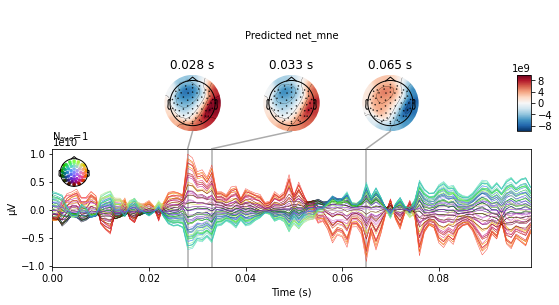

Using control points [0.23748201 0.25714947 0.36164214]
Using control points [0.         0.         0.32565327]
Using control points [0.23748201 0.25714947 0.36164214]


In [65]:
%matplotlib qt
settings = dict(duration_of_trial=0.1, extents=(1,20), number_of_sources=3)
sim_test = Simulation(fwd, info, settings=settings).simulate(2)
plot_params = dict(surface='white', hemi='both', verbose=0, clim=dict(kind='percent', pos_lims=(0,20,99)))

idx = 0
stc_true = sim_test.source_data[idx]
stc_true.data /= np.max(np.abs(stc_true.data))
stc_true.plot(**plot_params)
evoked = sim_test.eeg_data[idx].average()
evoked.plot_joint(title='Noisy Truth')
evoked = util.get_eeg_from_source(stc_true, fwd, info, tmin=0)
evoked.plot_joint(title='Unnoisy Truth')

stc = net.predict(sim_test)[idx]
stc.data /= np.max(np.abs(stc.data))
stc.plot(**plot_params)
evoked = util.get_eeg_from_source(stc, fwd, info, tmin=0)
evoked.plot_joint(title='Predicted Normal')

stc = net_mne.predict(sim_test)[idx]
stc.data /= np.max(np.abs(stc.data))
stc.plot(**plot_params)
evoked = util.get_eeg_from_source(stc, fwd, info, tmin=0)
evoked.plot_joint(title='Predicted net_mne')